In [19]:
using Pkg
Pkg.add(["MKL", "DifferentialEquations", "Symbolics", "Peaks", "CSV", "DataFrames", "JSON", "StatsBase", "Colors", "GLMakie", "Plots",  "Interpolations"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [20]:
using Pkg
using MKL
using DifferentialEquations, LinearAlgebra, SparseArrays, Symbolics, Peaks;
using CSV,DataFrames, JSON
using GLMakie
using StatsBase
using SparseArrays
using Plots
using Colors
using Interpolations
Makie.inline!(true)
include("utils.jl");

In [21]:
# load example data which is 2b3
df_load = CSV.read("../data/diffuse_spherical_sol.csv", DataFrame);

In [22]:
time = df_load.time
u_data = df_load.u
## parameters 
fixed_paras = JSON.parsefile("../data/fixed_parameters.json")
r_limit = fixed_paras["r_limit"]["value"]    # Maximum radial distance, unit um
N_r = fixed_paras["N_r"]["value"]           # Number of radial grid points
rgrid = range(0, stop=r_limit, length=N_r)
dr = step(rgrid);

### Visualize the time evolution of the the concentration field in 1D

In [23]:
## time points, here 1-t=0; 181-t=1/2h; 361-t=1h
time_points = [1, 181, 361] 
MAX_RADIUS = 10
# Extract profiles at the initial, middle, and last time steps
profile_1 = extract_data(u_data, time_points[1], 3) # Initial time step
profile_2 = extract_data(u_data, time_points[2], 3) # Middle time step
profile_3 = extract_data(u_data, time_points[3], 3) # Middle time step
# take the region of interest for plot, here 10um from the center of the nuclues
region_of_interest = rgrid .<= MAX_RADIUS
rgrid_filtered = rgrid[region_of_interest] 
profile_1_filtered = profile_1[region_of_interest]
profile_2_filtered = profile_2[region_of_interest]
profile_3_filtered = profile_3[region_of_interest];

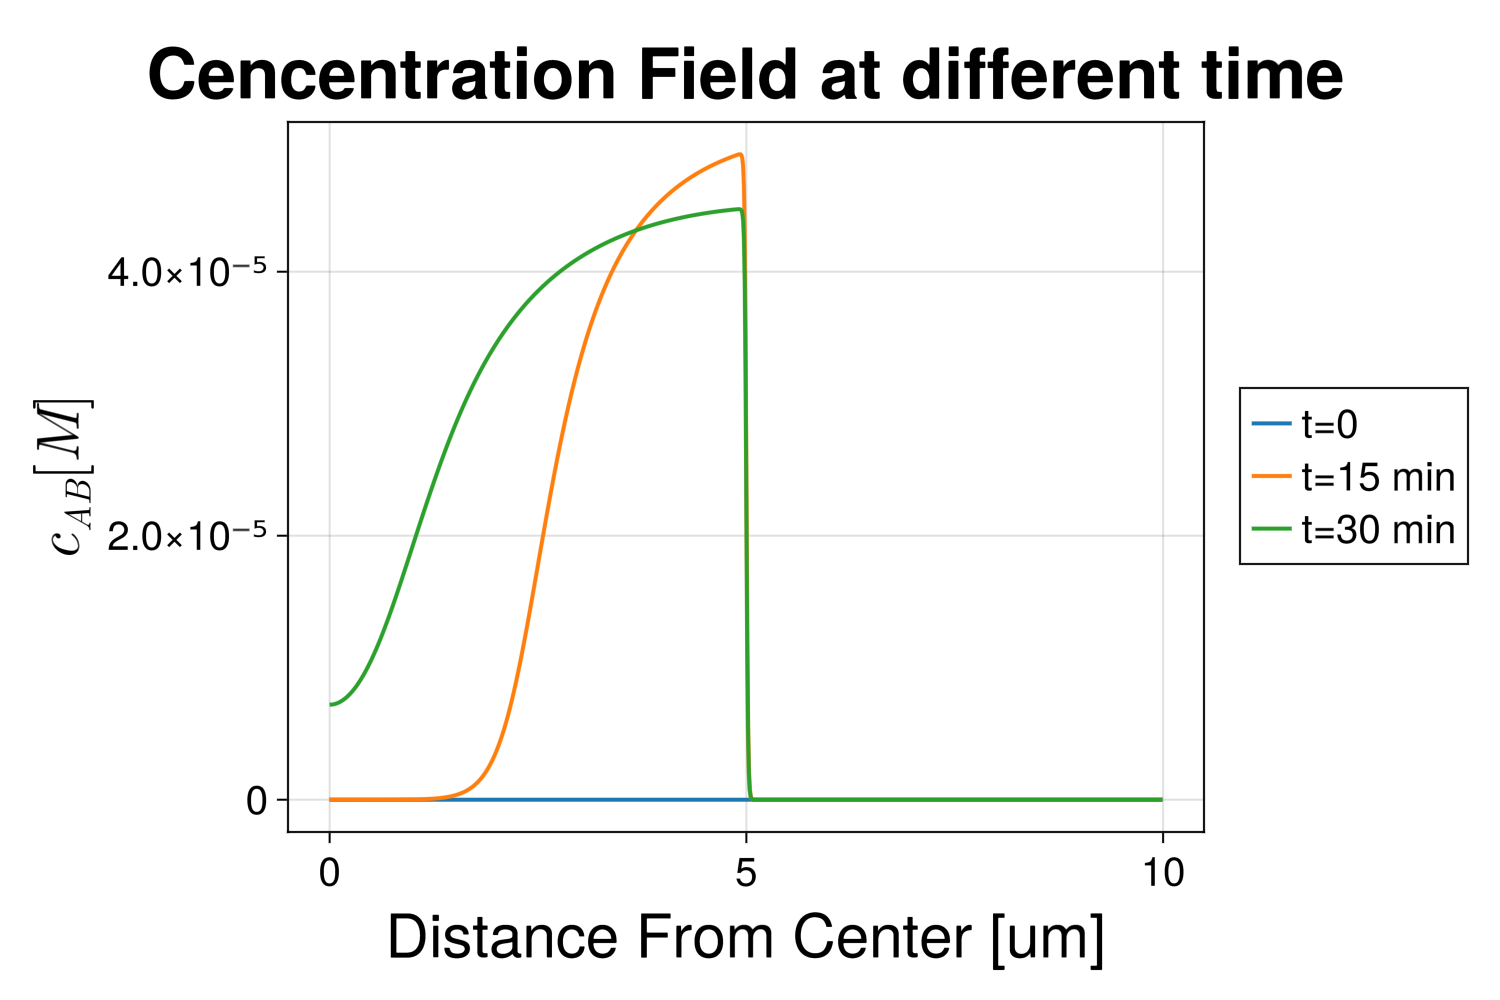

GLMakie.Screen(...)

In [26]:
fig = Figure(size = (750, 500), fontsize = 20)
# Create the axis
ax = Axis(fig[1, 1], title = "Cencentration Field at different time", 
        xlabel = "Distance From Center [um]", 
        ylabel=L"c_{AB} [M]",
        xlabelsize=30, ylabelsize=30, titlesize=35)

# Define the plot using the correct color names from the Colors.jl library
lines!(ax, rgrid_filtered, profile_1_filtered, label = "t=0", color = tab10_colors[1], linewidth = 2)
lines!(ax, rgrid_filtered, profile_2_filtered, label = "t=15 min", color = tab10_colors[2], linewidth = 2)
lines!(ax, rgrid_filtered, profile_3_filtered, label = "t=30 min", color = tab10_colors[3], linewidth = 2)

Legend(fig[1, 2], ax, position = :topright)
# Display the plot
display(fig)

### Visualize the concentration field at given timepoint, shows the concentration field at half-hour as an example

In [27]:
profile_half_hour = extract_data(u_data, time_points[2], 3) # Middle time step
region_of_interest = rgrid .<= MAX_RADIUS
rgrid_filtered = rgrid[region_of_interest] 
profile_half_hour_filtered = profile_half_hour[region_of_interest];

In [ ]:
## Can save the files
# using DelimitedFiles
# data_sub_plt = max.(profile_half_hour_filtered, 0)
# writedlm("x_array.txt", rgrid_filtered)
# writedlm("concentration_array.txt", data_sub_plt)
# x = readdlm("x_array.txt")  # Load data as an array
# data_half_hour = readdlm("concentration_array.txt")  # Load data as an array

In [28]:
# Assuming x and data_1_2 are arrays
data_sub_plt = max.(profile_half_hour_filtered, 0);
x_sub = rgrid_filtered[1:Int(length(data_sub_plt))];  # Select the first 'length(data_1_2)' elements from x
data_half_hour_sub = data_sub_plt[1:Int(length(data_sub_plt))];

In [29]:
x_sub_plt_center = rgrid_filtered[1:length(data_half_hour_sub)]
data_sub_plt_center = data_half_hour_sub[1:length(data_half_hour_sub)]
# Create interpolation function
interp = LinearInterpolation(x_sub_plt_center, data_sub_plt_center, extrapolation_bc=Line())
# Generate the radius image
radius_image = generate_radius_2D_new(2*MAX_RADIUS, 1000)
# Apply the function to the radius image using the interpolation
result_image = apply_function_to_radius(radius_image, interp)
# Apply maximum to ensure no negative values
result_image = max.(result_image, 0)
# Take log of the image for display
small_constant = 1e-15
result_image_log = log10.(result_image .+ small_constant);

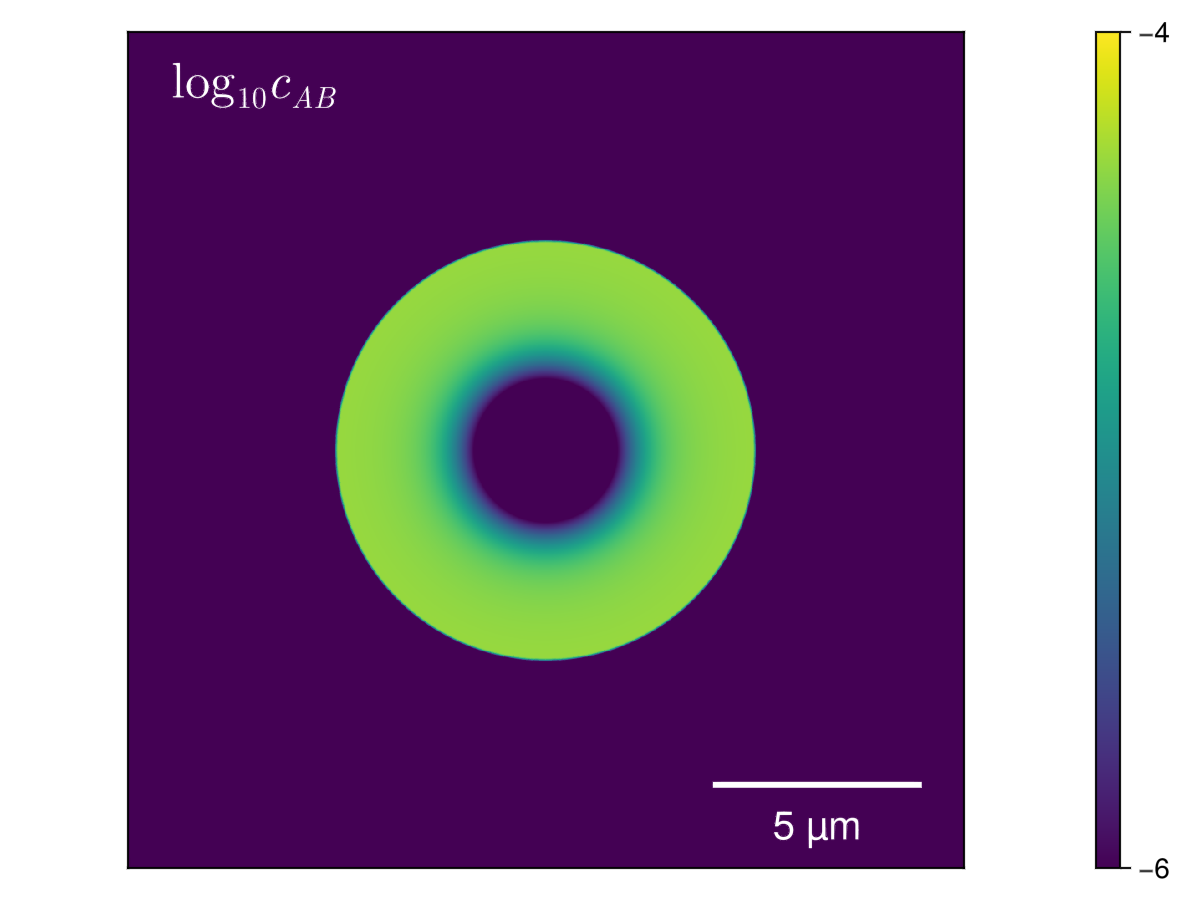

GLMakie.Screen(...)

In [30]:
# Create a figure
fig = Figure()
# Create an axis
ax = Axis(fig[1, 1], aspect=DataAspect())
# Create the heatmap using GLMakie's heatmap function, using a scale bar of range (-6, -4), may change
hm = GLMakie.heatmap!(ax, result_image_log, colorrange=(-6, -4))
# Remove decorations
hidedecorations!(ax)
# Add colorbar
cbar = Colorbar(fig[1, 2], hm, ticks=[-6, -4])
# Add text "log c_{AB}" next to the colorbar
annotate!(fig[1, 2], (1.05, 0.5), "log c_{AB}", color=:black, fontsize=12, align=:left)
# Display the figure

# Add scale bar
scalebar_length = 1000/4  # Length in data units (µm)
scalebar_position_x = 700
scalebar_position_y = 100
scalebar_height = 10 # Thickness of the bar

# Draw the scale bar line
lines!(ax, 
      [scalebar_position_x, scalebar_position_x + scalebar_length], 
      [scalebar_position_y, scalebar_position_y], 
      color=:white, linewidth=3)

# Add the scale bar text
text!(ax, 
     scalebar_position_x + scalebar_length/2, 
     scalebar_position_y - scalebar_height*2, 
     text="5 µm",
     color=:white, 
     align=(:center, :top),
     fontsize=20)

# Add a separate bar for log c_AB
bar_width = 200
bar_height = 30
bar_position_x = 50
bar_position_y = 1000   
text!(ax, 
     bar_position_x + bar_width/2, 
     bar_position_y - 30, 
     text = L"\log_{10}c_{AB}",
     align=(:center, :top), 
     color=:white, 
     fontsize=25)


display(fig)